In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [2]:
import math


x0: float = 1.0 
t_min = 0.0
t_max = 1.0 

hidden_size = 16 # number of neurons 
lr_adam = 1e-3 


seed = 1 


class MLP(nn.Module):
    def __init__(self,hidden_size = hidden_size , output_tanh = False):
        super().__init__()
        layers = [
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1), 
        ]
        if output_tanh:
            layers.append(nn.Tanh()) 
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, t):
        return self.mlp(t)
    


def choose_device(device = ""):
    if device:
        chosen = torch.device(device)
        if chosen.type == "mps": # 
            raise ValueError("MPS does not support float64")
        return chosen
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


def grad(outputs, inputs):
    return torch.autograd.grad( # compute derivative of outputs w.r.t. inputs 
        outputs,
        inputs,
        grad_outputs=torch.ones_like(outputs), # vector Jacobian product
        create_graph= True,  # because we will differentiate again 
        retain_graph=True,
    )[0]

def pde(x,t, omega): # your physical system
    dxdt = grad(x,t) # first derivative
    d2xdt2 = grad(dxdt, t) 
    return d2xdt2 +  (omega*omega)*x 


def model_loss(model_nn,t, x0_true , dx0dt_true, omega,bc_weight,  mse): # true initial value 
    x = model_nn(t) # neural network 
    f = pde(x,t,omega) # physical system 

    t0 = torch.zeros((1,1), dtype=t.dtype, device=t.device, requires_grad=True)
    x0_pred = model_nn(t0) 
    dx0dt_pred = grad(x0_pred,t0)

    loss_bc = mse(dx0dt_pred, dx0dt_true)
    loss_ic = mse(x0_pred,x0_true)
    loss_pde = mse(f, torch.zeros_like(f))

    loss = loss_pde + bc_weight*(loss_bc + loss_ic) # in this particular case: bc_weight 

    x_true = x0_true*torch.cos(omega*t) # true solution 
    loss_data = mse(x, x_true)

    metrics = {
        "loss_total": float(loss.detach().cpu()),
        "loss_bc": float(loss_bc.detach().cpu()),
        "loss_ic": float(loss_ic.detach().cpu()),
        "loss_pde": float(loss_pde.detach().cpu()),
        "loss_data": float(loss_data.detach().cpu()),
    }

    return loss, metrics


def train(model, device):
    omega = 2.0 * torch.pi 
    mse = nn.MSELoss()
    t = torch.linspace(t_min,t_max, 100, dtype=torch.float64, device=device,requires_grad=True).view(-1,1)
    x0_true = torch.tensor([[x0]], dtype=torch.float64,device= device)
    dx0dt_true = torch.zeros((1,1), dtype=torch.float64, device=device) # boundary condition 

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam)
    global train_loss_history
    train_loss_history = []

    for step in range(1,30000 + 1):
        optimizer.zero_grad() 
        loss_val, metrics = model_loss(
            model_nn=model,
            t=t,
            x0_true=x0_true,
            dx0dt_true=dx0dt_true,
            omega=omega,
            bc_weight=10,
            mse=mse
        )
        loss_val.backward()
        optimizer.step()
        train_loss_history.append(float(loss_val.detach().cpu()))

        if step ==1 or step % 4000 == 0:
            print(metrics)



In [3]:
device = choose_device("cpu")
torch.set_default_dtype(torch.float64)
model = MLP().to(device)
train(model,device)

{'loss_total': 115.33930627916304, 'loss_bc': 0.0003476173321046102, 'loss_ic': 1.5384815846077362, 'loss_pde': 99.95101425976463, 'loss_data': 0.5747111606398746}
{'loss_total': 0.005589297869810011, 'loss_bc': 1.46274917187792e-07, 'loss_ic': 1.45692120794801e-06, 'loss_pde': 0.005573265908558654, 'loss_data': 7.953470916503153e-07}
{'loss_total': 0.12695213407377026, 'loss_bc': 0.00016755428757787705, 'loss_ic': 7.002093179653716e-05, 'loss_pde': 0.12457638188002612, 'loss_data': 9.157681524034458e-05}
{'loss_total': 0.0032813648341740295, 'loss_bc': 2.6492324205105695e-07, 'loss_ic': 1.0396710295870334e-06, 'loss_pde': 0.0032683188914576487, 'loss_data': 5.598618898906667e-07}
{'loss_total': 0.0025657313283013405, 'loss_bc': 2.651432314919606e-08, 'loss_ic': 1.122767437634584e-07, 'loss_pde': 0.0025643434176322137, 'loss_data': 6.212620209050435e-08}
{'loss_total': 0.0018300049546335982, 'loss_bc': 1.9050801014563344e-08, 'loss_ic': 5.565142346926881e-08, 'loss_pde': 0.001829257932

Relative L2 error x(t): 7.4335e-05
Relative L2 error dx/dt: 1.0612e-04


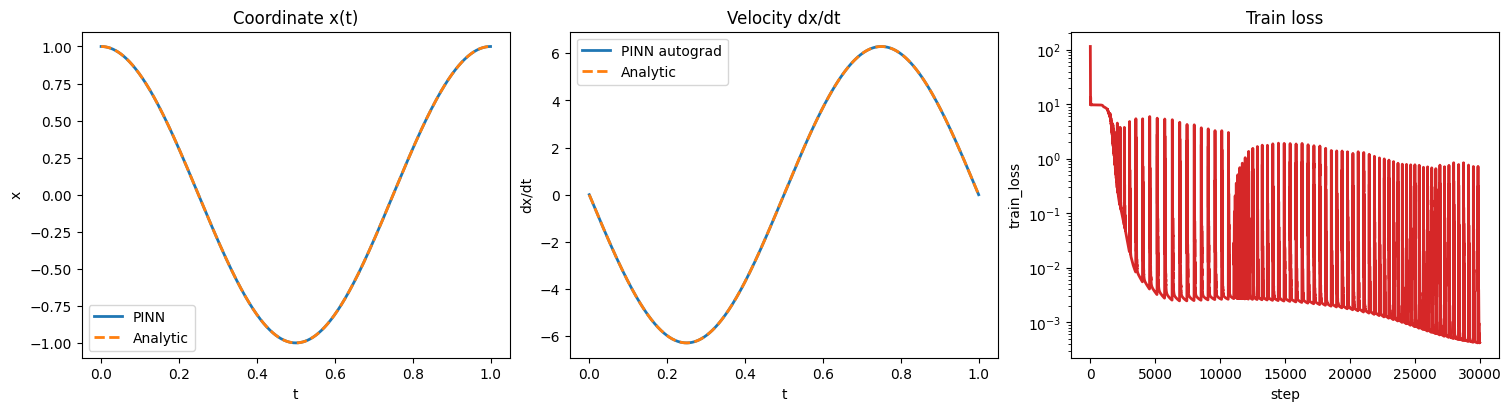

In [4]:
# Added diagnostics plots (appended, existing cells unchanged)
omega = 2.0 * torch.pi

t_eval = torch.linspace(t_min, t_max, 1000, dtype=torch.float64, device=device).view(-1, 1)
t_eval.requires_grad_(True)

model.eval()
x_pred = model(t_eval)
dxdt_pred = grad(x_pred, t_eval)

x_true = x0 * torch.cos(omega * t_eval)
dxdt_true = -x0 * omega * torch.sin(omega * t_eval)

rel_l2_x = float((torch.linalg.norm(x_pred - x_true) / torch.linalg.norm(x_true)).detach().cpu())
rel_l2_v = float((torch.linalg.norm(dxdt_pred - dxdt_true) / torch.linalg.norm(dxdt_true)).detach().cpu())
print(f"Relative L2 error x(t): {rel_l2_x:.4e}")
print(f"Relative L2 error dx/dt: {rel_l2_v:.4e}")

t_np = t_eval.detach().cpu().numpy().reshape(-1)
x_pred_np = x_pred.detach().cpu().numpy().reshape(-1)
x_true_np = x_true.detach().cpu().numpy().reshape(-1)
v_pred_np = dxdt_pred.detach().cpu().numpy().reshape(-1)
v_true_np = dxdt_true.detach().cpu().numpy().reshape(-1)
steps = np.arange(1, len(train_loss_history) + 1)
train_loss_np = np.array(train_loss_history)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

axes[0].plot(t_np, x_pred_np, '-', lw=2, label='PINN')
axes[0].plot(t_np, x_true_np, '--', lw=2, label='Analytic')
axes[0].set_title('Coordinate x(t)')
axes[0].set_xlabel('t')
axes[0].set_ylabel('x')
axes[0].legend()

axes[1].plot(t_np, v_pred_np, '-', lw=2, label='PINN autograd')
axes[1].plot(t_np, v_true_np, '--', lw=2, label='Analytic')
axes[1].set_title('Velocity dx/dt')
axes[1].set_xlabel('t')
axes[1].set_ylabel('dx/dt')
axes[1].legend()

axes[2].plot(steps, train_loss_np, lw=2, color='tab:red')
axes[2].set_yscale('log')
axes[2].set_title('Train loss')
axes[2].set_xlabel('step')
axes[2].set_ylabel('train_loss')

plt.show()
